# Text Mining - Course Project


*   Tal Lavi
*   Uriel Bender



## Imports (libraries and data) & installation of relevant libraries

In [26]:
!pip install langdetect
!pip install textblob
!pip install WordCloud
!pip install datasets
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=86ac75e3043e9ac33ed07d90e76051243aaeff23efdfa7fa0802816d68154027
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [41]:
import re
import pickle
from typing import List
import torch
import requests
from io import BytesIO
import zipfile
from scipy import stats # Import the stats module from scipy

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text Processing and NLP
from langdetect import detect
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Transformers (Hugging Face)
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Machine Learning Models
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# Preprocessing and Pipelines
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Miscellaneous
from google.colab import drive

drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
# Download the zip file from GitHub
url = "https://github.com/UrielBender/GPT_Sentiment_Analysis/raw/main/chatgpt_reviews.csv.zip"
response = requests.get(url)
response.raise_for_status()  # Raise an exception for bad status codes

# Extract the CSV file from the zip archive
with zipfile.ZipFile(BytesIO(response.content)) as z:
    with z.open("chatgpt_reviews.csv") as f:
        df = pd.read_csv(f)

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b55a8d30-80eb-4691-b77f-6331b327e429,Joe Edionwele,this app is great 👍,5,0,1.2024.331,2024-12-02 16:20:25,1.2024.331
1,edbc00a8-a9b7-4a9d-8161-2e50a6846775,Sobhika ks,It is very helpful,5,0,1.2024.331,2024-12-02 16:20:24,1.2024.331
2,8d6f4b66-88ad-44c4-ab17-397ae276d8db,Mohammad Sunny,All always helpful,5,0,1.2024.317,2024-12-02 16:20:05,1.2024.317
3,3b7d2fe0-f1d0-413b-b6a7-b86b1f589a17,alqasimiytravels,very good 💯 app,5,0,1.2024.324,2024-12-02 16:19:38,1.2024.324
4,fe6b2ab9-349d-4b11-a9ac-1e6c3335cfc9,Sadman Sarker,good,3,0,1.2024.331,2024-12-02 16:19:22,1.2024.331
5,c7b8637b-8f32-42cd-ba23-b2e9fabf3b2d,Alamin Sharif,এটা সত্যিই অনেক সুন্দর একটা অ্যাপস যে আমাকে রী...,5,0,NaN,2024-12-02 16:19:11,NaN


## EDA

In [33]:
print(df.info())
df.head(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287353 entries, 0 to 287352
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              287353 non-null  object
 1   userName              287351 non-null  object
 2   content               287344 non-null  object
 3   score                 287353 non-null  int64 
 4   thumbsUpCount         287353 non-null  int64 
 5   reviewCreatedVersion  262438 non-null  object
 6   at                    287353 non-null  object
 7   appVersion            262438 non-null  object
dtypes: int64(2), object(6)
memory usage: 17.5+ MB
None


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,b55a8d30-80eb-4691-b77f-6331b327e429,Joe Edionwele,this app is great 👍,5,0,1.2024.331,2024-12-02 16:20:25,1.2024.331
1,edbc00a8-a9b7-4a9d-8161-2e50a6846775,Sobhika ks,It is very helpful,5,0,1.2024.331,2024-12-02 16:20:24,1.2024.331
2,8d6f4b66-88ad-44c4-ab17-397ae276d8db,Mohammad Sunny,All always helpful,5,0,1.2024.317,2024-12-02 16:20:05,1.2024.317
3,3b7d2fe0-f1d0-413b-b6a7-b86b1f589a17,alqasimiytravels,very good 💯 app,5,0,1.2024.324,2024-12-02 16:19:38,1.2024.324
4,fe6b2ab9-349d-4b11-a9ac-1e6c3335cfc9,Sadman Sarker,good,3,0,1.2024.331,2024-12-02 16:19:22,1.2024.331
5,c7b8637b-8f32-42cd-ba23-b2e9fabf3b2d,Alamin Sharif,এটা সত্যিই অনেক সুন্দর একটা অ্যাপস যে আমাকে রী...,5,0,NaN,2024-12-02 16:19:11,NaN


In [34]:
df.describe()

,score,thumbsUpCount
count,287353.000000,287353.000000
mean,4.511016,0.287208
std,1.077219,9.473615
min,1.000000,0.000000
25%,5.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1193.000000


In [35]:
# Identify and display missing values
print("\nMissing values:")
print(df.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df.duplicated().sum())
df .shape



Missing values:
reviewId                    0
userName                    2
content                     9
score                       0
thumbsUpCount               0
reviewCreatedVersion    24915
at                          0
appVersion              24915
dtype: int64

Number of duplicate rows: 2509


(287353, 8)

In [36]:
# Convert 'reviewCreatedVersion' and 'appVersion' to numeric
df['appVersion_numeric'] = df['appVersion'].str.replace('.', '')  # Remove dots
df['appVersion_numeric'] = pd.to_numeric(df['appVersion_numeric'], errors='coerce')  # Convert to integer (or NaN for invalid values)

df['reviewCreatedVersion_numeric'] = df['reviewCreatedVersion'].str.replace('.', '')  # Remove dots
df['reviewCreatedVersion_numeric'] = pd.to_numeric(df['reviewCreatedVersion_numeric'], errors='coerce')  # Convert to integer (or NaN for invalid values)


# Calculate correlation using the numeric columns
correlation = df['reviewCreatedVersion_numeric'].corr(df['appVersion_numeric'])

print(f"\nCorrelation between reviewCreatedVersion and appVersion: {correlation}")


Correlation between reviewCreatedVersion and appVersion: 1.0


In [37]:
df = df.drop(columns=['reviewCreatedVersion_numeric', 'reviewCreatedVersion'], errors='ignore')

In [38]:
# Display the frequency of each unique value in each column (for categorical columns)
for col in df.columns:
  if df[col].dtype == 'object':  # Check for object/string data type
    print(f"\nFrequency counts for column '{col}':")
    print(df[col].value_counts())



Frequency counts for column 'reviewId':
reviewId
e4c800c7-3971-40ec-bb51-bd71f282cc99    10
4299411b-fb16-4785-970f-b57ebb484857     9
fc30300a-cd03-4e18-8c00-ba8005a70065     8
a968c178-3080-4b54-bd59-91286d2c3617     8
85bb98c7-0288-4f30-a098-42bd79757c4b     8
                                        ..
fc7b4206-1f34-4e75-bc09-fdfdedf96d34     1
f77b803d-e158-477d-9085-d25eba0970eb     1
717a3c5b-cb2b-41f0-b139-09dd175d2a97     1
8e78dfe5-7992-4256-ab1e-769b409be38f     1
0151001d-b81c-41b5-8927-f56738989625     1
Name: count, Length: 282826, dtype: int64

Frequency counts for column 'userName':
userName
Rahul Kumar            65
Amit Kumar             62
A Google user          61
Rohit Kumar            59
Abhishek Kumar         57
                       ..
Hafiz Abubakar          1
Om Joshi                1
Abdullah Al mamun       1
Aegon Levi Ackerman     1
Tushar Deran            1
Name: count, Length: 259819, dtype: int64

Frequency counts for column 'content':
content
good     

In [39]:
print(df.appVersion.nunique())
print(df.appVersion.value_counts())

# rows of the df where the df.appVersion.value_counts() is lower than 10
app_version_counts = df.appVersion.value_counts()
less_than_10 = app_version_counts[app_version_counts < 10].index
filtered_df = df[df.appVersion.isin(less_than_10)]
filtered_df.score.value_counts()

94
appVersion
1.2024.268    16052
1.2024.226    15897
1.2024.206    12391
1.2024.177     8820
1.2024.131     8775
              ...  
1.2024.024        2
1.2023.270        2
1.2023.277        2
1.2024.033        1
1.2023.275        1
Name: count, Length: 94, dtype: int64


,count
score,
5,36
4,8
1,5
3,2
2,1


In [42]:
# Convert the 'at' column to numeric before calculating the Z-score
df['at'] = pd.to_datetime(df['at'])
df['at_numeric'] = df['at'].astype('int64')  # Convert to numerical representation

# Now calculate the Z-score using the numeric column
z = np.abs(stats.zscore(df['at_numeric']))

threshold = 3  # You can adjust the threshold
abnormal_data_zscore = df[(z > threshold)]

print("\nAbnormal data points (using Z-score):")
print(abnormal_data_zscore)


Abnormal data points (using Z-score):
Empty DataFrame
Columns: [reviewId, userName, content, score, thumbsUpCount, at, appVersion, appVersion_numeric, at_numeric]
Index: []


In [43]:
# remove 50% rows and still keep the score column distribution same

# Calculate the proportion of each score in the original dataframe
score_proportions = df['score'].value_counts(normalize=True)

# Sample 50% of the rows while preserving score distribution
sampled_df = df.groupby('score').sample(frac=0.5, random_state=42)

# Check the score distribution in the sampled data
sampled_score_proportions = sampled_df['score'].value_counts(normalize=True)

print("Original score proportions:\n", score_proportions)
print("\nSampled score proportions:\n", sampled_score_proportions)
print(df.shape)
print(sampled_df.shape)


Original score proportions:
 score
5    0.767826
4    0.113449
1    0.060365
3    0.041005
2    0.017355
Name: proportion, dtype: float64

Sampled score proportions:
 score
5    0.767819
4    0.113449
1    0.060365
3    0.041009
2    0.017358
Name: proportion, dtype: float64
(287353, 9)
(143677, 9)


## Visuals

In [44]:
df.thumbsUpCount.value_counts()

,count
thumbsUpCount,
0,281287
1,3651
2,786
3,326
4,166
...,...
637,1
744,1
1068,1


In [45]:
# drop the thumbsUpCount column
df = df.drop(columns=['thumbsUpCount'], errors='ignore')

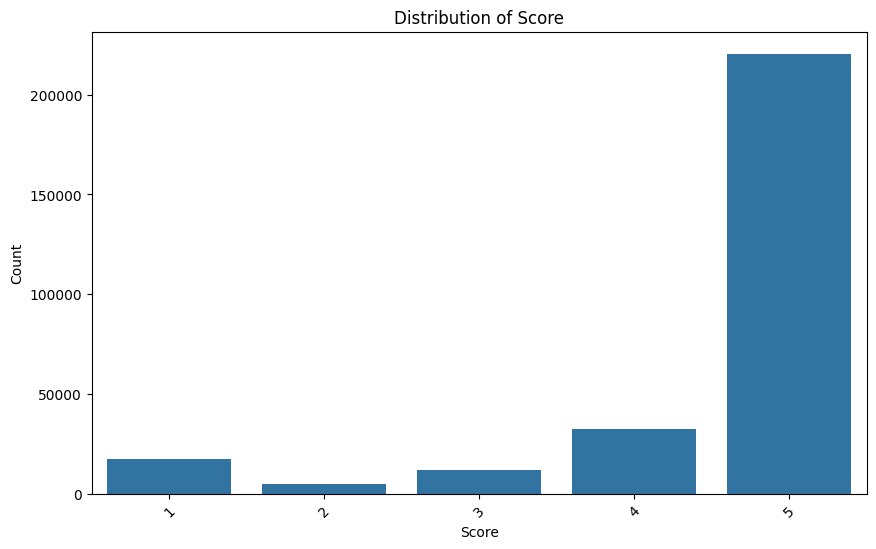

In [46]:
# Visualize the distribution of 'score'
plt.figure(figsize=(10, 6))
sns.countplot(x='score', data=df)
plt.title('Distribution of Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [47]:
import plotly.graph_objects as go

# Sample data (replace with your actual data)
scores = df['score'].value_counts()

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=scores.index, values=scores.values, textinfo='label+percent+value')])

# Customize the layout (optional)
fig.update_layout(title='Score Distribution')

# Show the chart
fig.show()

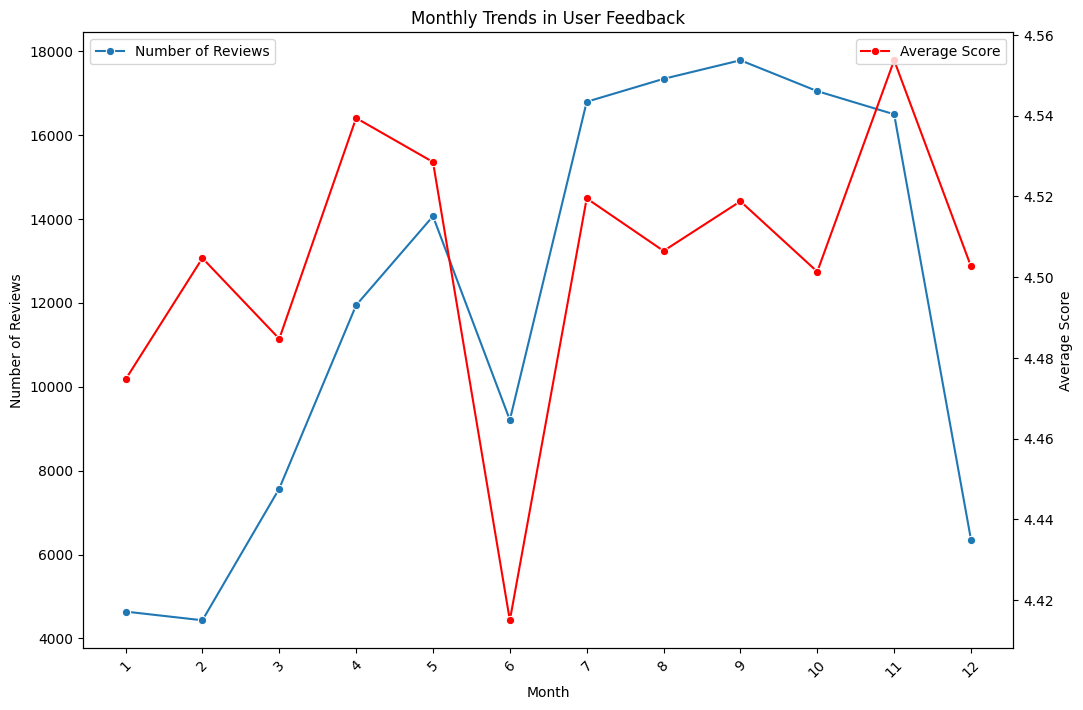

In [48]:
# Visualizing trends in user feedback over time
# Convert 'at' to datetime
sampled_df['at'] = pd.to_datetime(df['at'])

# Extract the month
sampled_df['month'] = sampled_df['at'].dt.month  # Assign the month to a new 'month' column

# Now groupby using the new column to calculate monthly reviews and average score
monthly_reviews = sampled_df.groupby('month').agg({'reviewId': 'count', 'score': 'mean'}).reset_index()

# Converting the 'month' column to string format for plotting
monthly_reviews['month'] = monthly_reviews['month'].astype(str)

# Handling infinite values by converting them to NaN
monthly_reviews.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plotting the number of reviews and average score over time
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting the number of reviews
sns.lineplot(x='month', y='reviewId', data=monthly_reviews, marker='o', ax=ax1, label='Number of Reviews')
ax1.set_ylabel('Number of Reviews')
ax1.set_xlabel('Month')
ax1.set_title('Monthly Trends in User Feedback')
ax1.tick_params(axis='x', rotation=45)

# Creating a second y-axis for average score
ax2 = ax1.twinx()
sns.lineplot(x='month', y='score', data=monthly_reviews, marker='o', ax=ax2, color='r', label='Average Score')
ax2.set_ylabel('Average Score')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

## Detect and delete all Non-English Data and add sentiments columns to the data using TextBlob

<ipython-input-49-d9df9f44900d>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-d9df9f44900d>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-49-d9df9f44900d>:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



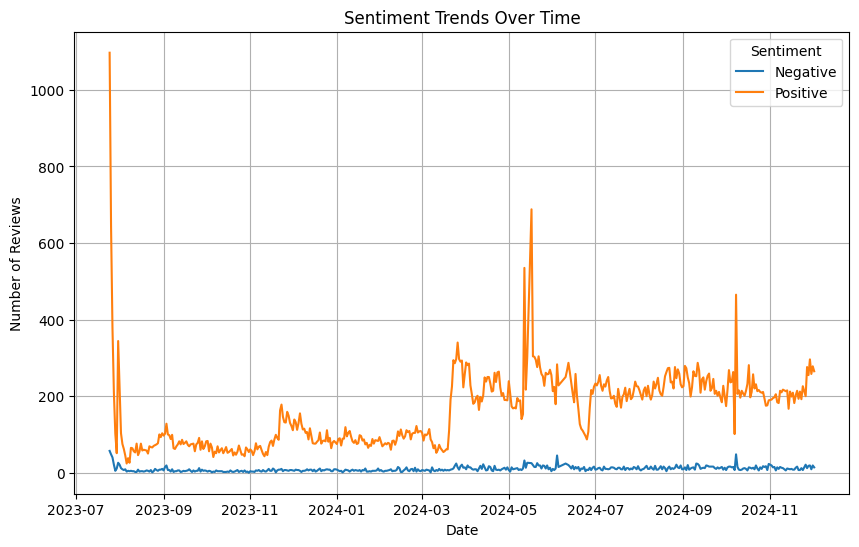

In [49]:
# Function to detect the language of the text
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Detect language for the 'content' column
sampled_df['language'] = sampled_df['content'].apply(detect_language)

# Filter for English-only reviews
df_english = sampled_df[sampled_df['language'] == 'en']

# Sentiment analysis using TextBlob
def analyze_sentiment(text):
    analysis = TextBlob(text)
    # Polarity: -1 (negative) to 1 (positive)
    return analysis.sentiment.polarity

df_english['sentiment_score'] = df_english['content'].apply(analyze_sentiment)

# Classify sentiment as Positive, Neutral, or Negative
def classify_sentiment(score):
    if score >= 0.0:
        return 'Positive'
    elif score < -0.0:
        return 'Negative'

df_english['sentiment'] = df_english['sentiment_score'].apply(classify_sentiment)

# Plot sentiment trends over time
df_english['at'] = pd.to_datetime(df_english['at'])  # Convert 'at' column to datetime
sentiment_trend = df_english.groupby(df_english['at'].dt.date)['sentiment'].value_counts().unstack(fill_value=0)

# Plot the trends
sentiment_trend.plot(kind='line', figsize=(10, 6))
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.grid()
plt.show()


In [50]:
# Save the filtered and analyzed dataset
print(df_english.shape)
# df_english.to_csv('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/filtered_reviews_val.csv', index=False) #TODO change to filtered_reviews

(82585, 13)


# START HERE AFTER IMPORTING TO READ ENGLISH FILTERING



In [52]:
url = "https://raw.githubusercontent.com/UrielBender/GPT_Sentiment_Analysis/main/filtered_reviews_val.csv"

try:
    df_english = pd.read_csv(url)
except Exception as e:
    print(f"An error occurred: {e}")

df_english.head(2)

,reviewId,userName,content,score,thumbsUpCount,at,appVersion,appVersion_numeric,at_numeric,month,language,sentiment_score,sentiment
0,01b79324-902e-4c64-a0cc-e14b8fd8717c,Magdalena Škreblin,It's not working,1,0,2024-06-04 07:40:45,NaN,NaN,1717486845000000000,6,en,0.0,Positive
1,5716e8a5-9cd1-4c57-8277-f5e3debf1c3d,Epic Noob,It doesn't work at all (sending messages simpl...,1,2,2024-07-08 15:52:29,1.2024.177,12024177.0,1720453949000000000,7,en,0.0,Positive


In [53]:
df_english.drop(columns=['at_numeric'], inplace=True)

In [54]:
df_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82468 entries, 0 to 82467
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            82468 non-null  object 
 1   userName            82467 non-null  object 
 2   content             82468 non-null  object 
 3   score               82468 non-null  int64  
 4   thumbsUpCount       82468 non-null  int64  
 5   at                  82468 non-null  object 
 6   appVersion          74621 non-null  object 
 7   appVersion_numeric  74621 non-null  float64
 8   month               82468 non-null  int64  
 9   language            82468 non-null  object 
 10  sentiment_score     82468 non-null  float64
 11  sentiment           82468 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 7.6+ MB


## EDA 2nd Phase

In [55]:
df_english['at'] = pd.to_datetime(df_english['at'])

# add The day of the week with Monday=0, Sunday=6
df_english['day_of_week'] = df_english['at'].dt.weekday

# add column user_review_count that count the number of revies for each unique usrename
df_english['user_review_count'] = df_english.groupby('userName')['userName'].transform('count')

# Bin the 'comment length' column into 10 bins
df_english['comment_length_binned'] = pd.cut(df_english['content'].str.len(), bins=10, labels=False)


df_english.head(2)

,reviewId,userName,content,score,thumbsUpCount,at,appVersion,appVersion_numeric,month,language,sentiment_score,sentiment,day_of_week,user_review_count,comment_length_binned
0,01b79324-902e-4c64-a0cc-e14b8fd8717c,Magdalena Škreblin,It's not working,1,0,2024-06-04 07:40:45,NaN,NaN,6,en,0.0,Positive,1,1.0,0
1,5716e8a5-9cd1-4c57-8277-f5e3debf1c3d,Epic Noob,It doesn't work at all (sending messages simpl...,1,2,2024-07-08 15:52:29,1.2024.177,12024177.0,7,en,0.0,Positive,0,1.0,1


In [56]:
# Identify and display missing values
print("\nMissing values:")
print(df_english.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df_english.duplicated().sum())



Missing values:
reviewId                    0
userName                    1
content                     0
score                       0
thumbsUpCount               0
at                          0
appVersion               7847
appVersion_numeric       7847
month                       0
language                    0
sentiment_score             0
sentiment                   0
day_of_week                 0
user_review_count           1
comment_length_binned       0
dtype: int64

Number of duplicate rows: 519


In [57]:
null_count = df_english['appVersion_numeric'].isnull().sum()
percentage_null = (null_count / len(df_english)) * 100
print(f"Percentage of null values in 'appVersion_numeric': {percentage_null:.2f}%")

Percentage of null values in 'appVersion_numeric': 9.52%


In [58]:
df_english.drop(['language', 'reviewId', 'thumbsUpCount', 'appVersion'], axis=1, inplace=True)
df_english.dropna(subset=['userName'], inplace=True)
df_english.drop_duplicates(inplace=True)

# Fill NaN values in 'appVersion_numeric' with the most frequent value
most_frequent_app_version = df_english['appVersion_numeric'].mode()[0]
df_english['appVersion_numeric'] = df_english['appVersion_numeric'].fillna(most_frequent_app_version)

# Identify and display missing values
print("\nMissing values:")
print(df_english.isnull().sum())

# Check for duplicate rows
print("\nNumber of duplicate rows:", df_english.duplicated().sum())



Missing values:
userName                 0
content                  0
score                    0
at                       0
appVersion_numeric       0
month                    0
sentiment_score          0
sentiment                0
day_of_week              0
user_review_count        0
comment_length_binned    0
dtype: int64

Number of duplicate rows: 0


In [59]:
df_english[['score', 'appVersion_numeric', 'month', 'sentiment_score', 'day_of_week' , 'user_review_count', 'comment_length_binned']].describe()

,score,appVersion_numeric,month,sentiment_score,day_of_week,user_review_count,comment_length_binned
count,81947.000000,8.194700e+04,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000
mean,4.422395,1.122159e+07,7.248490,0.409036,2.927526,1.191246,0.857957
std,1.165618,2.987470e+06,2.954109,0.362038,1.993303,1.078287,1.679332
min,1.000000,1.000160e+05,1.000000,-1.000000,0.000000,1.000000,0.000000
25%,4.000000,1.202405e+07,5.000000,0.144444,1.000000,1.000000,0.000000
50%,5.000000,1.202416e+07,8.000000,0.400000,3.000000,1.000000,0.000000
75%,5.000000,1.202425e+07,10.000000,0.700000,5.000000,1.000000,1.000000
max,5.000000,1.202433e+07,12.000000,1.000000,6.000000,21.000000,9.000000


## Visuals

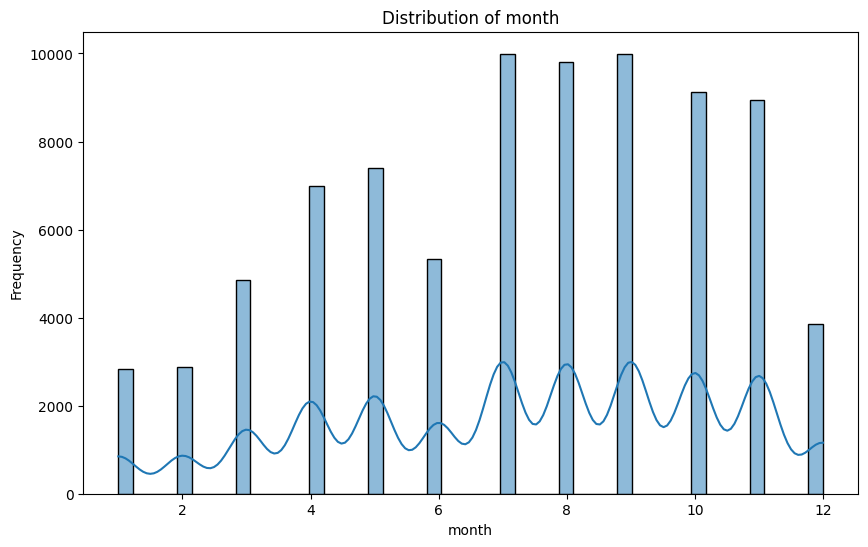

In [60]:
# Visualize the distribution of 'at'
plt.figure(figsize=(10, 6))
sns.histplot(df_english['month'], kde=True)
plt.title('Distribution of month')
plt.xlabel('month')
plt.ylabel('Frequency')
plt.show()

comment_length_binned
0    4.596816
1    4.276992
2    4.101619
3    3.934688
4    3.850061
5    3.809659
6    3.744186
7    3.811828
8    3.864444
9    3.791111
Name: score, dtype: float64


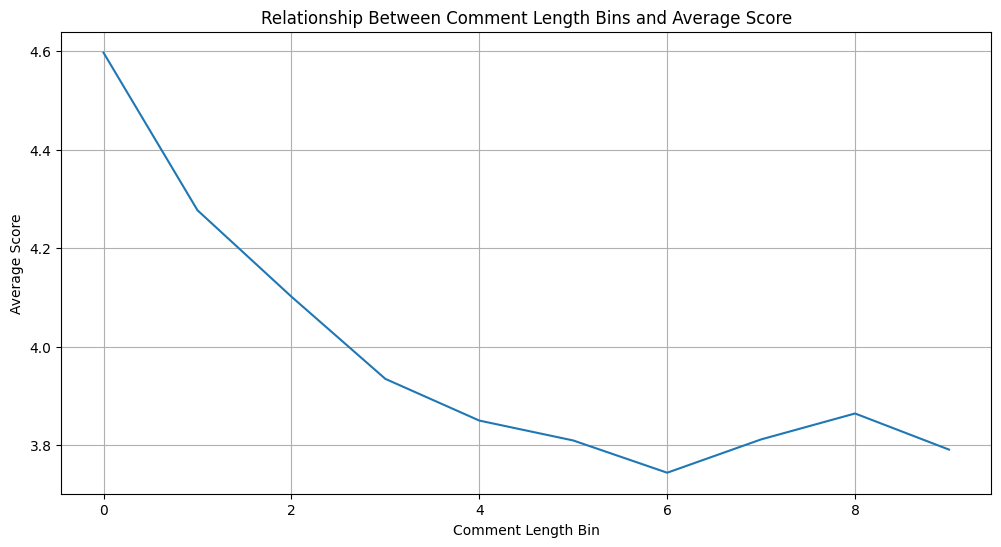

In [61]:
# Now you can use 'comment_length_binned' for further analysis or visualization
# For example, to see the average score per bin
average_score_by_bin = df_english.groupby('comment_length_binned')['score'].mean()
print(average_score_by_bin)

# Visualize the relationship between comment length bins and the average score
plt.figure(figsize=(12, 6))
plt.plot(average_score_by_bin.index, average_score_by_bin.values)
plt.xlabel('Comment Length Bin')
plt.ylabel('Average Score')
plt.title('Relationship Between Comment Length Bins and Average Score')
plt.grid(True)
plt.show()

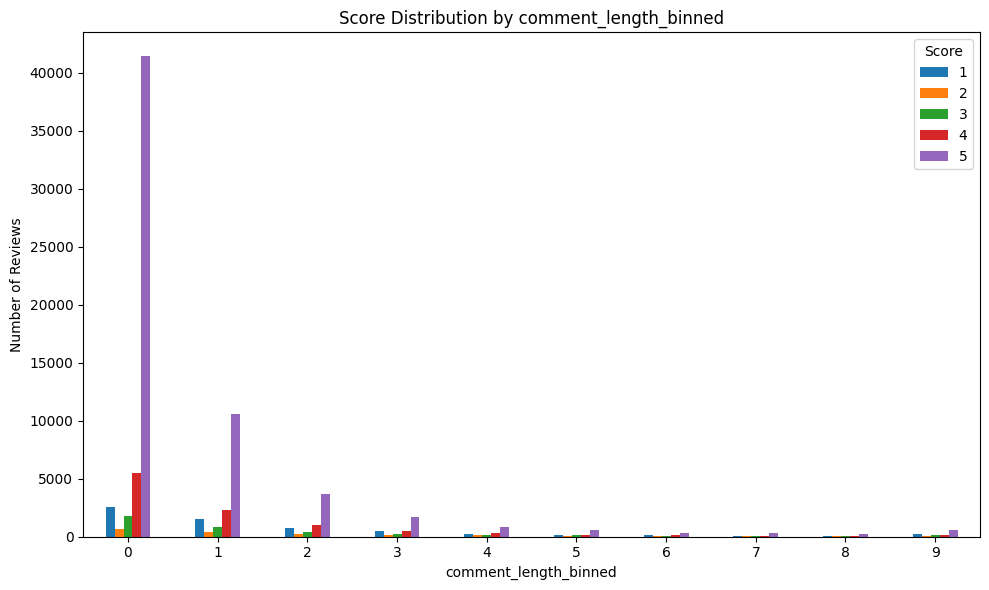

In [12]:
# plot chart that represents the connection between the day_of_week and the score relation to it
# foe each day plot 5 bars that represent the count of each score according to day


# Group the data by day_of_week and score
day_score_counts = df_english.groupby(['comment_length_binned', 'score']).size().unstack(fill_value=0)

# Create the bar plot
ax = day_score_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Score Distribution by comment_length_binned')
plt.xlabel('comment_length_binned')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Score')
plt.tight_layout()
plt.show()

In [62]:
PS = PorterStemmer()
# Change the list of languages to 'english' to load English stopwords.
# You can add other language codes if needed, like ['english', 'spanish']
STPWRDS = set(stopwords.words('english'))
# If you want to add specific words to your stopword list, do it after loading the standard English stopwords:
STPWRDS.update(['app', 'chatgpt'])

def clean_doc(doc: str) -> List[str]:
    # remove all non-English-letters characters
    clean = re.sub('[^a-zA-Z!]', ' ', doc)
    # Phase 1: Lowercase
    doc = clean.lower()
    # Phase 2: Split into tokens
    doc = doc.split()
    # Phase 3: Remove Stopwords
    doc = [w for w in doc if not w in STPWRDS]
    # Phase 4: Stem into stems
    doc = [PS.stem(w) for w in doc]
    return doc



df_english['cleaned_content'] = df_english['content'].apply(clean_doc)

In [14]:
df_english.head(2)

,userName,content,score,at,appVersion_numeric,at_numeric,month,sentiment_score,sentiment,day_of_week,user_review_count,comment_length_binned,cleaned_content
0,Magdalena Škreblin,It's not working,1,2024-06-04 07:40:45,12024268.0,1717486845000000000,6,0.0,Positive,1,1.0,0,[work]
1,Epic Noob,It doesn't work at all (sending messages simpl...,1,2024-07-08 15:52:29,12024177.0,1720453949000000000,7,0.0,Positive,0,1.0,1,"[work, send, messag, simpli, show, error]"


In [63]:
# change the cleaned_content column to a string seperate by space (" ")

def join_cleaned_content(content_list):
    return " ".join(content_list)

df_english['cleaned_content'] = df_english['cleaned_content'].apply(join_cleaned_content)
df_english.head(2)

,userName,content,score,at,appVersion_numeric,month,sentiment_score,sentiment,day_of_week,user_review_count,comment_length_binned,cleaned_content
0,Magdalena Škreblin,It's not working,1,2024-06-04 07:40:45,12024268.0,6,0.0,Positive,1,1.0,0,work
1,Epic Noob,It doesn't work at all (sending messages simpl...,1,2024-07-08 15:52:29,12024177.0,7,0.0,Positive,0,1.0,1,work send messag simpli show error


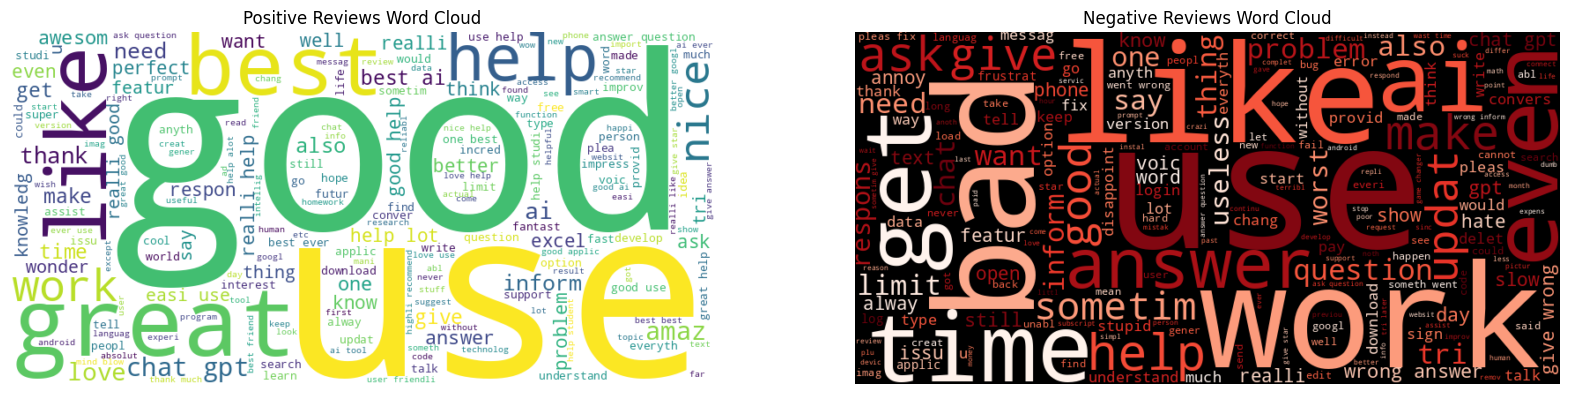

In [64]:
# Generating word clouds for positive and negative reviews
# Convert sentiment to lowercase for comparison
df_english['sentiment'] = df_english['sentiment'].str.lower()

positive_reviews = ' '.join(df_english[df_english['sentiment'] == 'positive']['cleaned_content'])
negative_reviews = ' '.join(df_english[df_english['sentiment'] == 'negative']['cleaned_content'])

# Check if positive_reviews and negative_reviews are empty
if not positive_reviews:
  print("Warning: No positive reviews found for word cloud generation.")
if not negative_reviews:
  print("Warning: No negative reviews found for word cloud generation.")

positive_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STPWRDS).generate(positive_reviews)
negative_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=STPWRDS).generate(negative_reviews)

# Plotting the word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(positive_wordcloud, interpolation='bilinear')
ax1.set_title('Positive Reviews Word Cloud')
ax1.axis('off')

ax2.imshow(negative_wordcloud, interpolation='bilinear')
ax2.set_title('Negative Reviews Word Cloud')
ax2.axis('off')

plt.show()

## Rearange Data Set befor model impementations

In [65]:
df_english.drop(['userName'], axis=1, inplace=True)
df_english.shape

In [19]:
df_english.head(2)

,content,score,at,appVersion_numeric,at_numeric,month,sentiment_score,sentiment,day_of_week,user_review_count,comment_length_binned,cleaned_content
0,It's not working,1,2024-06-04 07:40:45,12024268.0,1717486845000000000,6,0.0,positive,1,1.0,0,[work]
1,It doesn't work at all (sending messages simpl...,1,2024-07-08 15:52:29,12024177.0,1720453949000000000,7,0.0,positive,0,1.0,1,"[work, send, messag, simpli, show, error]"


In [20]:
df_english.describe()

,score,at,appVersion_numeric,at_numeric,month,sentiment_score,day_of_week,user_review_count,comment_length_binned
count,81947.000000,81947,8.194700e+04,8.194700e+04,81947.000000,81947.000000,81947.000000,81947.000000,81947.000000
mean,4.422395,2024-05-14 12:29:21.038268416,1.122159e+07,1.715690e+18,7.248490,0.409036,2.927526,1.191246,0.857957
min,1.000000,2023-07-25 15:01:35,1.000160e+05,1.690297e+18,1.000000,-1.000000,0.000000,1.000000,0.000000
25%,4.000000,2024-02-19 06:04:16,1.202405e+07,1.708323e+18,5.000000,0.144444,1.000000,1.000000,0.000000
50%,5.000000,2024-06-01 05:32:54,1.202416e+07,1.717220e+18,8.000000,0.400000,3.000000,1.000000,0.000000
75%,5.000000,2024-09-03 16:13:06.500000,1.202425e+07,1.725380e+18,10.000000,0.700000,5.000000,1.000000,1.000000
max,5.000000,2024-12-02 16:20:25,1.202433e+07,1.733156e+18,12.000000,1.000000,6.000000,21.000000,9.000000
std,1.165618,NaN,2.987470e+06,1.185284e+16,2.954109,0.362038,1.993303,1.078287,1.679332


### cut 90% of the data but keep the score column distribution equal as possible

In [20]:


def cut_data_preserve_distribution(df, cut_percentage=0.9):
    """Cuts a DataFrame while maintaining the score column distribution.

    Args:
        df: The input DataFrame.
        cut_percentage: The percentage of rows to remove (e.g., 0.9 to remove 90%).

    Returns:
        A new DataFrame with reduced size and proportional score distribution.
    """

    # Calculate the number of rows to keep
    rows_to_keep = int(len(df) * (1 - cut_percentage))

    # Group by 'score' and sample proportionally
    sampled_df = df.groupby('score').apply(lambda x: x.sample(n=int(rows_to_keep * (len(x) / len(df))), random_state=42))

    # Reset index
    sampled_df = sampled_df.reset_index(drop=True)

    return sampled_df

reduced_df = cut_data_preserve_distribution(df_english, cut_percentage=0.9)

# Verify the distribution
print("Original score proportions:\n", df_english['score'].value_counts(normalize=True))
print("\nReduced score proportions:\n", reduced_df['score'].value_counts(normalize=True))
print(f"\nOriginal shape: {df_english.shape}, Reduced shape: {reduced_df.shape}")

Original score proportions:
 score
5    0.734731
4    0.123372
1    0.074560
3    0.046018
2    0.021319
Name: proportion, dtype: float64

Reduced score proportions:
 score
5    0.734953
4    0.123306
1    0.074472
3    0.046026
2    0.021243
Name: proportion, dtype: float64

Original shape: (81947, 12), Reduced shape: (8191, 12)


<ipython-input-20-684383d28879>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('score').apply(lambda x: x.sample(n=int(rows_to_keep * (len(x) / len(df))), random_state=42))


### BaseLine Benchmark

In [21]:
# This classifier serves as a simple baseline to compare against other more complex classifiers.

# Define features (X) and target variable (y)
X = df_english['cleaned_content']  # Use cleaned content as features
y = df_english['score']  # Use 'score' as the target variable

# Convert list of lists to strings for TF-IDF
X = [' '.join(review) for review in X]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a DummyClassifier (most_frequent strategy)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

# Make predictions on the test set
dummy_predictions = dummy_clf.predict(X_test)

# Evaluate the DummyClassifier (example: using classification_report)
print(classification_report(y_test, dummy_predictions))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1177
           2       0.00      0.00      0.00       360
           3       0.00      0.00      0.00       754
           4       0.00      0.00      0.00      1973
           5       0.74      1.00      0.85     12126

    accuracy                           0.74     16390
   macro avg       0.15      0.20      0.17     16390
weighted avg       0.55      0.74      0.63     16390



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Model implementations

### TD-IDF

In [22]:
# Load the dataset
df = df_english.copy()

# Preprocessing: Textual Data
tfidf = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed

# Preprocessing: Numeric Features
numeric_features = ['sentiment_score', 'month','day_of_week', 'user_review_count', 'comment_length_binned']
scaler = StandardScaler()

# Preprocessing: Combine NLP + Numeric Features
preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', tfidf, 'cleaned_content'),  # Text feature
        ('num', scaler, numeric_features)  # Numeric features
    ]
)

# Define the model (now a classifier)
model = GradientBoostingClassifier()

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Train-test split
X = df.drop(columns=['score', 'at'])  # Exclude target and irrelevant columns
y = df['score'] # Target variable is now 'sentiment'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.61      0.46      0.52      1177
           2       0.16      0.01      0.03       360
           3       0.37      0.03      0.06       754
           4       0.44      0.06      0.11      1973
           5       0.79      0.99      0.88     12126

    accuracy                           0.77     16390
   macro avg       0.47      0.31      0.32     16390
weighted avg       0.70      0.77      0.70     16390



### distilbert

In [23]:
# Load the dataset
df = reduced_df.copy()

# Hugging Face Model Setup
# Specify the pretrained model (e.g., "distilbert-base-uncased")
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Function to generate embeddings using Hugging Face model
def generate_embeddings(text, tokenizer, model, device='cpu'):
    """Generate sentence embeddings from a pretrained Hugging Face model."""
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean pooling of the last hidden state as the embedding
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Generate embeddings for the content column
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Apply embeddings generation (batch processing to improve speed)
def batch_embed_text(text_series, tokenizer, model, batch_size=16):
    embeddings = []
    for i in range(0, len(text_series), batch_size):
        batch_texts = text_series[i:i+batch_size].tolist()
        batch_embeddings = generate_embeddings(batch_texts, tokenizer, model, device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings for the content column
embeddings = batch_embed_text(df['cleaned_content'], tokenizer, model)

# Convert embeddings array to a DataFrame
embedding_columns = [f'embedding_{i}' for i in range(embeddings.shape[1])]  # Adjust size as per embedding dimensions
embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)

# Merge embeddings with your main dataset
df_combined = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)


numeric_features = ['sentiment_score', 'month', 'day_of_week', 'user_review_count', 'comment_length_binned']
features = numeric_features + embedding_columns

# Define features (X) and target (y)
X = df_combined[features]
y = df_combined['score']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Define the model
model = GradientBoostingClassifier()

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/distilbert_model.pkl', 'wb') as file:
    pickle.dump(model, file)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

              precision    recall  f1-score   support

           1       0.60      0.38      0.47       206
           2       0.08      0.02      0.03        50
           3       0.26      0.07      0.12       107
           4       0.28      0.05      0.09       317
           5       0.78      0.97      0.86      1778

    accuracy                           0.75      2458
   macro avg       0.40      0.30      0.31      2458
weighted avg       0.66      0.75      0.68      2458



## distilbert on full dataset (most susseful results)

In [ ]:

# Load the dataset
df = df_english.copy()

# Hugging Face Model Setup
# Specify the pretrained model (e.g., "distilbert-base-uncased")
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Function to generate embeddings using Hugging Face model
def generate_embeddings(text, tokenizer, model, device='cpu'):
    """Generate sentence embeddings from a pretrained Hugging Face model."""
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean pooling of the last hidden state as the embedding
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Generate embeddings for the content column
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Apply embeddings generation (batch processing to improve speed)
def batch_embed_text(text_series, tokenizer, model, batch_size=16):
    embeddings = []
    for i in range(0, len(text_series), batch_size):
        batch_texts = text_series[i:i+batch_size].tolist()
        batch_embeddings = generate_embeddings(batch_texts, tokenizer, model, device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings for the content column
embeddings = batch_embed_text(df['content'], tokenizer, model)

# Convert embeddings array to a DataFrame
embedding_columns = [f'embedding_{i}' for i in range(embeddings.shape[1])]  # Adjust size as per embedding dimensions
embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)

# Merge embeddings with your main dataset
df_combined = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)


numeric_features = ['sentiment_score', 'month', 'day_of_week', 'user_review_count', 'comment_length_binned']
features = numeric_features + embedding_columns

# Define features (X) and target (y)
X = df_combined[features]
y = df_combined['score']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the model
model = GradientBoostingClassifier()

# Fit the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/distilbert_model.pkl', 'wb') as file:
    pickle.dump(model, file)

              precision    recall  f1-score   support

           1       0.61      0.65      0.63      1816
           2       0.23      0.05      0.08       531
           3       0.27      0.04      0.06      1105
           4       0.39      0.13      0.20      2989
           5       0.83      0.98      0.89     18144

    accuracy                           0.79     24585
   macro avg       0.47      0.37      0.37     24585
weighted avg       0.72      0.79      0.74     24585



In [21]:


df = df_english.copy()

# Check and use CUDA if available
cuda_available = False
try:
    import torch
    cuda_available = torch.cuda.is_available()
    device = 'cuda' if cuda_available else 'cpu'
    print(f"Using device: {device}")
except ImportError:
    print("Torch not installed, defaulting to CPU")

# Load pre-trained model (assuming it produces embeddings)
with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/distilbert_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# # Load pre-trained model (assuming it produces embeddings) from GitHub
# url = "https://github.com/UrielBender/GPT_Sentiment_Analysis/raw/main/distilbert_model.pkl"  # Use 'raw' to get the file content directly
# response = requests.get(url)
# response.raise_for_status()  # Raise an exception for bad status codes

# # Load the model from the downloaded file
# loaded_model = pickle.load(BytesIO(response.content))


# Train-test split
X = df.drop(columns=['score', 'at', 'content', 'sentiment', 'cleaned_content'])  # Exclude target and irrelevant columns + text data
y = df['score'] # Target variable

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Shift target variable before oversampling ---
y_train = y_train - 1  # Shift labels to start from 0
y_test = y_test - 1    # Shift labels in the test set as well


# Oversample minority classes
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(
    random_state=42,
    tree_method='gpu_hist' if cuda_available else 'auto',  # Use GPU if available
    predictor='gpu_predictor' if cuda_available else 'cpu_predictor',
    eval_metric='logloss',
    use_label_encoder=False
)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1  # Parallel processing
)

# Train the model with resampled data
print("Starting GridSearchCV...")
grid_search.fit(X_train_resampled, y_train_resampled)

# Retrieve the best model from GridSearch
best_xgb_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the best model on the test set
y_pred = best_xgb_model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))


Using device: cpu
Starting GridSearchCV...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [21:57:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.52      0.36      1816
           1       0.06      0.15      0.08       531
           2       0.06      0.13      0.08      1105
           3       0.14      0.23      0.17      2989
           4       0.83      0.58      0.68     18144

    accuracy                           0.50     24585
   macro avg       0.27      0.32      0.28     24585
weighted avg       0.66      0.50      0.56     24585



In [ ]:
# Copy dataframe
df = df_english.copy()

# Check and use CUDA if available
cuda_available = False
try:
    import torch
    cuda_available = torch.cuda.is_available()
    device = 'cuda' if cuda_available else 'cpu'
    print(f"Using device: {device}")
except ImportError:
    print("Torch not installed, defaulting to CPU")

# Load pre-trained model (assuming it produces embeddings)
with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/\u05e9\u05e0\u05d4 \u05d1/\u05db\u05e8\u05d9\u05d9\u05ea \u05d8\u05e7\u05e1\u05d8/Text_Mining-Course_Project/distilbert_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# # Load pre-trained model (assuming it produces embeddings) from GitHub
# url = "https://github.com/UrielBender/GPT_Sentiment_Analysis/raw/main/distilbert_model.pkl"  # Use 'raw' to get the file content directly
# response = requests.get(url)
# response.raise_for_status()  # Raise an exception for bad status codes

# # Load the model from the downloaded file
# loaded_model = pickle.load(BytesIO(response.content))


# Train-test split
X = df.drop(columns=['score', 'at', 'content', 'sentiment', 'cleaned_content'])  # Exclude target and irrelevant columns + text data
y = df['score']  # Target variable

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Shift target variable before oversampling ---
#X_train_resampled = y_train - 1  # Incorrect: This shifts the features, not the target
y_train_resampled = y_train_resampled - 1  # Correct: Shift the target variable (y)
y_test = y_test - 1    # Shift labels in the test set as well

# Parameter grids for RandomForest and LogisticRegression
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500]
}

# Initialize classifiers
rf_model = RandomForestClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)

# Perform GridSearchCV for RandomForest
print("Starting GridSearchCV for RandomForest...")
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Best RandomForest model
best_rf_model = rf_grid_search.best_estimator_
print(f"Best RandomForest Parameters: {rf_grid_search.best_params_}")

# Evaluate RandomForest
y_pred_rf = best_rf_model.predict(X_test)
print("RandomForest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Perform GridSearchCV for LogisticRegression
print("Starting GridSearchCV for LogisticRegression...")
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid_search.fit(X_train_resampled, y_train_resampled)

# Best LogisticRegression model
best_lr_model = lr_grid_search.best_estimator_
print(f"Best LogisticRegression Parameters: {lr_grid_search.best_params_}")

# Evaluate LogisticRegression
y_pred_lr = best_lr_model.predict(X_test)
print("LogisticRegression Classification Report:")
print(classification_report(y_test, y_pred_lr))


In [24]:
# Load the dataset
df = reduced_df.copy()

# Hugging Face Model Setup
# Specify the pretrained model (e.g., "distilbert-base-uncased")
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# Function to generate embeddings using Hugging Face model
def generate_embeddings(text, tokenizer, model, device='cpu'):
    """Generate sentence embeddings from a pretrained Hugging Face model."""
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: tensor.to(device) for key, tensor in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        # Use the mean pooling of the last hidden state as the embedding
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings.cpu().numpy()

# Generate embeddings for the content column
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Apply embeddings generation (batch processing to improve speed)
def batch_embed_text(text_series, tokenizer, model, batch_size=16):
    embeddings = []
    for i in range(0, len(text_series), batch_size):
        batch_texts = text_series[i:i+batch_size].tolist()
        # Convert list of tokens back to string for each review
        batch_texts = [' '.join(tokens) for tokens in batch_texts]
        batch_embeddings = generate_embeddings(batch_texts, tokenizer, model, device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Generate embeddings for the content column
embeddings = batch_embed_text(df['cleaned_content'], tokenizer, model)

# Convert embeddings array to a DataFrame
embedding_columns = [f'embedding_{i}' for i in range(embeddings.shape[1])]  # Adjust size as per embedding dimensions
embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)

# Merge embeddings with your main dataset
df_combined = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)


numeric_features = ['sentiment_score', 'month', 'day_of_week', 'user_review_count', 'comment_length_binned']
features = numeric_features + embedding_columns

# Define features (X) and target (y)
X = df_combined[features]
y = df_combined['score']  # Target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Shift target variable before oversampling ---
#X_train_resampled = y_train - 1  # Incorrect: This shifts the features, not the target
y_train_resampled = y_train_resampled - 1  # Correct: Shift the target variable (y)
y_test = y_test - 1    # Shift labels in the test set as well

# Define the model
model = GradientBoostingClassifier()

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/distilbert_model_SMOTE.pkl', 'wb') as file:
    pickle.dump(model, file)


              precision    recall  f1-score   support

           0       0.43      0.53      0.48       206
           1       0.09      0.14      0.11        50
           2       0.13      0.22      0.17       107
           3       0.22      0.29      0.25       317
           4       0.87      0.75      0.80      1778

    accuracy                           0.64      2458
   macro avg       0.35      0.39      0.36      2458
weighted avg       0.70      0.64      0.66      2458



In [ ]:

# Apply SMOTE to the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# --- Shift target variable before oversampling ---
#X_train_resampled = y_train - 1  # Incorrect: This shifts the features, not the target
y_train_resampled = y_train_resampled - 1  # Correct: Shift the target variable (y)
y_test = y_test - 1    # Shift labels in the test set as well


# Define the model
model = GradientBoostingClassifier()

# Fit the model
model.fit(X_train_resampled, y_train_resampled)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


with open('/content/drive/MyDrive/Msc - ניהול טכנולוגיה ודאטה סיינס/שנה ב/כריית טקסט/Text_Mining-Course_Project/distilbert_model_SMOTE.pkl', 'wb') as file:
    pickle.dump(model, file)

## FineTuned DistilBert Best Model - NOT RUNNING (unfortunately this script not finish until the presentations in the class..)

In [ ]:
# Load the dataset
df = reduced_df.copy()

# Prepare target labels (0-based index)
df['score'] = df['score'] - 1

# Numerical features to include
numerical_features = ['sentiment_score', 'month', 'day_of_week', 'user_review_count', 'comment_length_binned']

# Step 1: Fine-Tune Hugging Face Model for Sequence Classification
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Train-test split for Hugging Face model
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_content'], df['score'], test_size=0.3, random_state=42
)

def tokenize_function(examples):
    return tokenizer(examples, padding="max_length", truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts.tolist())
test_encodings = tokenize_function(test_texts.tolist())

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_dict({"input_ids": train_encodings['input_ids'],
                                   "attention_mask": train_encodings['attention_mask'],
                                   "labels": train_labels})
test_dataset = Dataset.from_dict({"input_ids": test_encodings['input_ids'],
                                  "attention_mask": test_encodings['attention_mask'],
                                  "labels": test_labels})

# Load Pre-trained Model for Sequence Classification
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=5)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2
)

# Define evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the Model
print("Fine-tuning Hugging Face model...")
trainer.train()

# Save the fine-tuned model
model.save_pretrained("finetuned_distilbert_model")
tokenizer.save_pretrained("finetuned_distilbert_model")


In [ ]:

# Generate Embeddings Using Fine-Tuned Model
def generate_embeddings(text_list):
    embeddings = []
    model.eval()  # Set the model to evaluation mode
    for text_tokens in text_list:  # Iterate over lists of tokens
        text = ' '.join(text_tokens)  # Join tokens back into a string
        inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512).to(model.device)
        with torch.no_grad():
            outputs = model.distilbert(**inputs)  # Assuming 'distilbert' is the base model
            embedding = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(embedding[0])
    return np.array(embeddings)

print("Generating embeddings for Gradient Boosting...")
embeddings = generate_embeddings(df['cleaned_content'].tolist())
embedding_columns = [f"embedding_{i}" for i in range(embeddings.shape[1])]
embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)

# Combine embeddings with numerical features
df_combined = pd.concat([df.reset_index(drop=True), embedding_df], axis=1)
features = numerical_features + embedding_columns
X = df_combined[features]
y = df_combined['score']

# Train-test split for Gradient Boosting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Gradient Boosting Classifier
print("Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_scaled, y_train)

# Predict and Evaluate
print("Evaluating the Gradient Boosting model...")
y_pred = gb_model.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the Gradient Boosting Model
with open("gradient_boosting_with_embeddings.pkl", "wb") as file:
    pickle.dump(gb_model, file)

print("Gradient Boosting model saved as 'gradient_boosting_with_embeddings.pkl'")
